In [1]:
import cv2
print(cv2.__version__)

ModuleNotFoundError: No module named 'cv2'

In [3]:
import os
#import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model

ModuleNotFoundError: No module named 'numpy'

In [13]:
def load_data(folder_path, img_size=(48,48)):
    images = []
    labels = []
    classes = sorted(os.listdir(folder_path))  # Sorted for consistent label order

    for idx, emotion in enumerate(classes):
        emotion_folder = os.path.join(folder_path, emotion)
        for img_file in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(idx)
    
    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1) / 255.0
    labels = to_categorical(labels, num_classes=len(classes))
    return images, labels, classes

In [ ]:
def create_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        # input layer
        tf.keras.layers.Input(shape=(48,48,1)),  # Input() instead of input_shape in Conv2D
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # 1st hidden dense layer
        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # 2nd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # 3rd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # Flatten layer
        tf.keras.layers.Flatten(),
    
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        
        # output layer
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    

In [14]:
'''
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
'''

In [15]:
def plot_training_history(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

In [16]:
def train_emotion_model(data_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=(48,48),
        color_mode='grayscale',
        batch_size=64,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=(48,48),
        color_mode='grayscale',
        batch_size=64,
        class_mode='categorical'
    )

    model = create_model((48,48,1), len(train_generator.class_indices))

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint('emotion_model.h5', save_best_only=True, monitor='val_loss')

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=[early_stop, checkpoint]
    )

    print("[INFO] Model saved as emotion_model.h5")

    plot_training_history(history)

    return list(train_generator.class_indices.keys())



In [17]:
def real_time_emotion_detector(classes):
    model = load_model('emotion_model.h5')
    cap = cv2.VideoCapture(0)

    face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

        for (x, y, w, h) in faces:
            face = gray_frame[y:y+h, x:x+w]
            face = cv2.resize(face, (48,48))
            face = face.reshape(1,48,48,1) / 255.0

            prediction = model.predict(face)
            emotion_label = classes[np.argmax(prediction)]

            cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 2)
            cv2.putText(frame, emotion_label, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)

        cv2.imshow('Emotion Detection', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/50
449/449 [==============================] - 93s 205ms/step - loss: 1.8164 - accuracy: 0.2424 - val_loss: 1.7843 - val_accuracy: 0.2533
Epoch 2/50


C:\ProgramData\anaconda3\envs\emoenv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


449/449 [==============================] - 81s 180ms/step - loss: 1.7901 - accuracy: 0.2523 - val_loss: 1.7432 - val_accuracy: 0.2896
Epoch 3/50
449/449 [==============================] - 81s 179ms/step - loss: 1.7564 - accuracy: 0.2744 - val_loss: 1.6867 - val_accuracy: 0.3213
Epoch 4/50
449/449 [==============================] - 82s 183ms/step - loss: 1.7205 - accuracy: 0.2991 - val_loss: 1.5837 - val_accuracy: 0.3865
Epoch 5/50
449/449 [==============================] - 80s 178ms/step - loss: 1.6635 - accuracy: 0.3306 - val_loss: 1.4964 - val_accuracy: 0.4110
Epoch 6/50
449/449 [==============================] - 79s 177ms/step - loss: 1.6100 - accuracy: 0.3610 - val_loss: 1.4694 - val_accuracy: 0.4342
Epoch 7/50
449/449 [==============================] - 82s 182ms/step - loss: 1.5675 - accuracy: 0.3826 - val_loss: 1.4127 - val_accuracy: 0.4606
Epoch 8/50
449/449 [==============================] - 80s 178ms/step - loss: 1.5352 - accuracy: 0.4015 - val_loss: 1.3588 - val_accuracy: 0.4

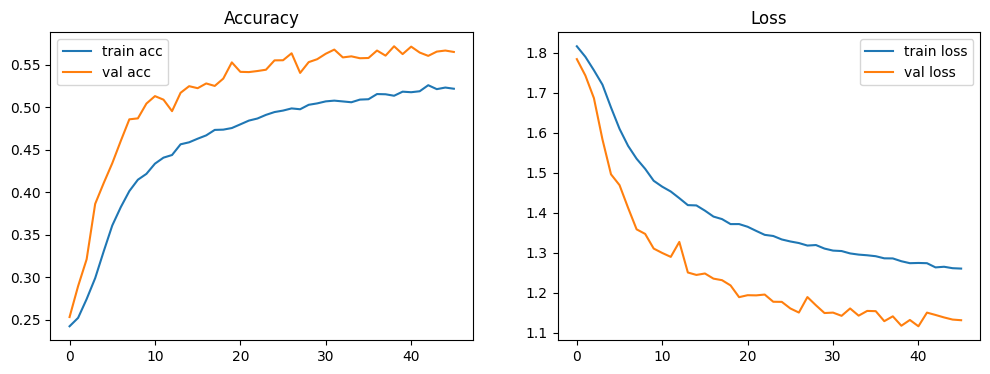

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [18]:
train_emotion_model("C:/Users/Admin/Documents/Projects/Emotion_Detection/Dataset/")

In [20]:
def train_emotion_model_mobilenet(data_dir, img_size=(48,48), batch_size=64, epochs=100):
    # Data generators
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=img_size,
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=img_size,
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Model
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(train_generator.num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
    checkpoint = ModelCheckpoint('mobilenet_emotion_model.h5', save_best_only=True, monitor='val_loss')

    # Train
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stop, reduce_lr, checkpoint]
    )

    plot_training_history(history)

    return model

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/100
449/449 [==============================] - 103s 222ms/step - loss: 1.8484 - accuracy: 0.2681 - val_loss: 1.7534 - val_accuracy: 0.3019 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 90s 199ms/step - loss: 1.7868 - accuracy: 0.2934 - val_loss: 1.7229 - val_accuracy: 0.3236 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 90s 200ms/step - loss: 1.7755 - accuracy: 0.2995 - val_loss: 1.7177 - val_accuracy: 0.3331 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 92s 205ms/step - loss: 1.7635 - accuracy: 0.3059 - val_loss: 1.7057 - val_accuracy: 0.3401 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 91s 203ms/step - loss: 1.7587 - accuracy: 0.3097 - val_loss: 1.7131 - val_accuracy: 0.3345 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 9

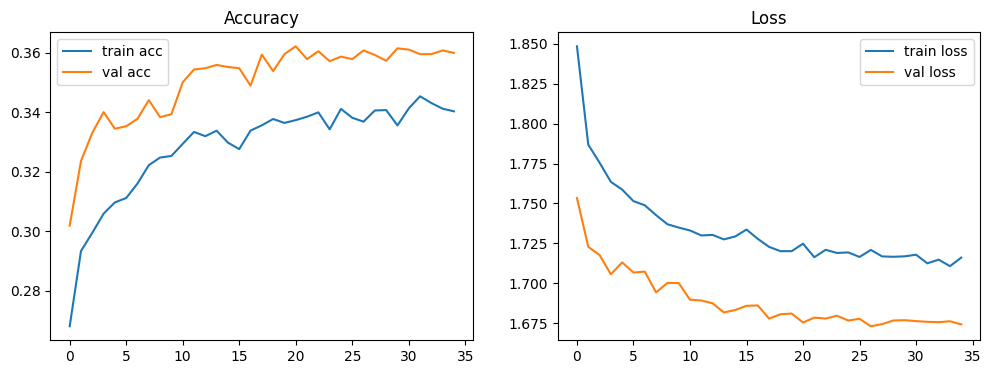

In [21]:
train_emotion_model_mobilenet("C:/Users/Admin/Documents/Projects/Emotion_Detection/Dataset/")